# Уровень средней заработной платы в России

Известны данные о заработной плате за каждый месяц с января 1993 по август 2016, необходимо построить прогноз на следующие двагода.

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


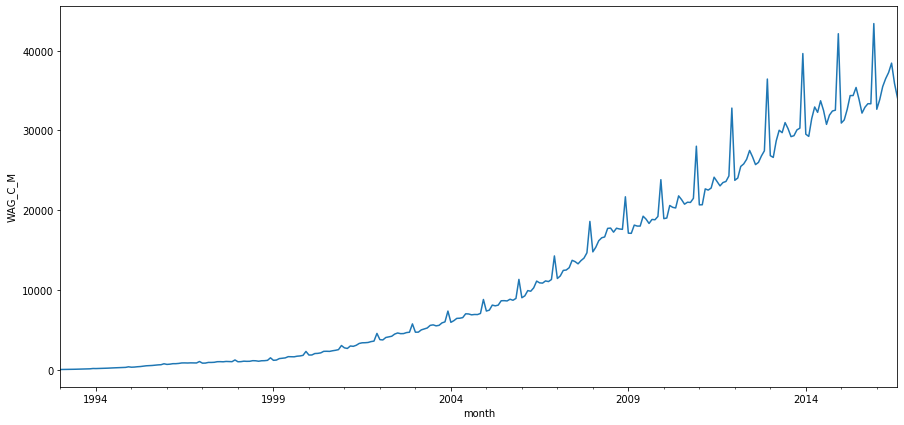

In [3]:
wage = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
wage['WAG_C_M'].plot()
plt.ylabel('WAG_C_M')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

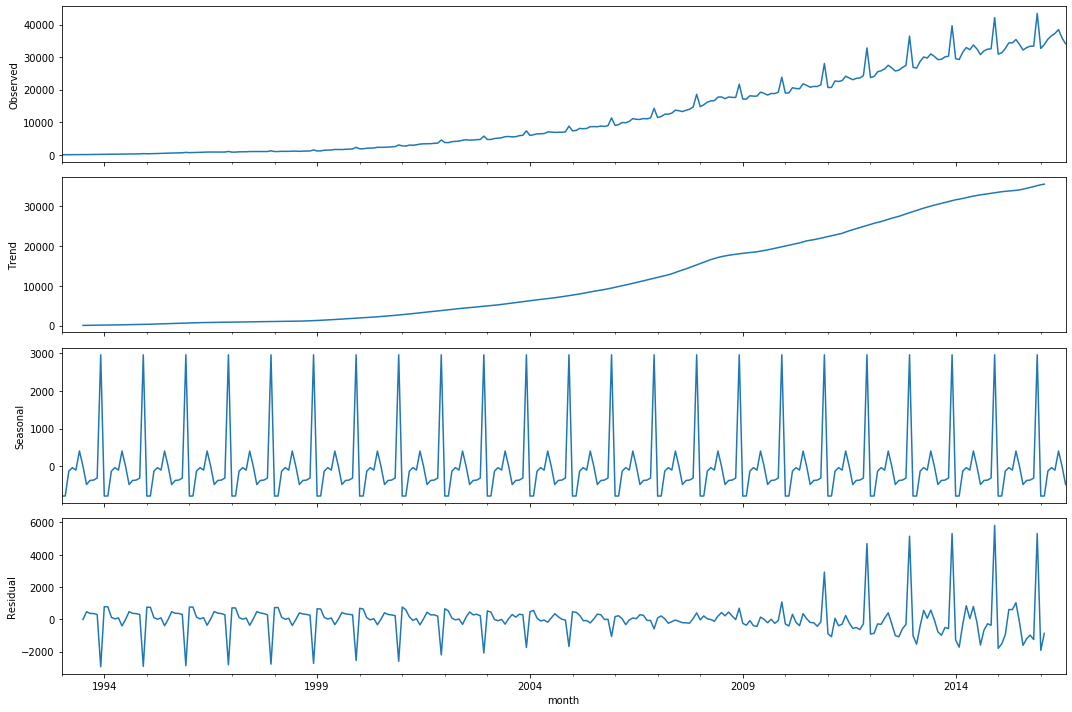

In [4]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage['WAG_C_M']).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage['WAG_C_M'])[1])

### Стабилизация дисперсии

Видно что в начале дисперсия значительно меньше чем в конце. Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


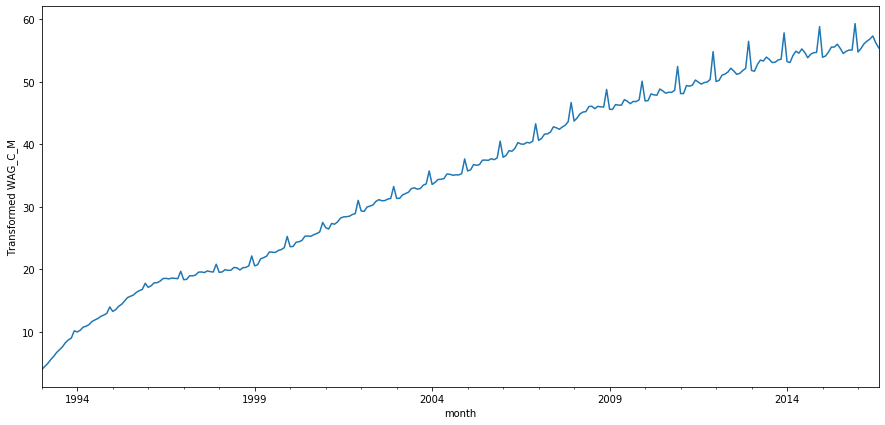

In [8]:
wage['WAG_C_M_box'], lmbda = stats.boxcox(wage['WAG_C_M'])
plt.figure(figsize(15,7))
wage['WAG_C_M_box'].plot()
plt.ylabel(u'Transformed WAG_C_M')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage['WAG_C_M_box'])[1])

### Стационарность

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

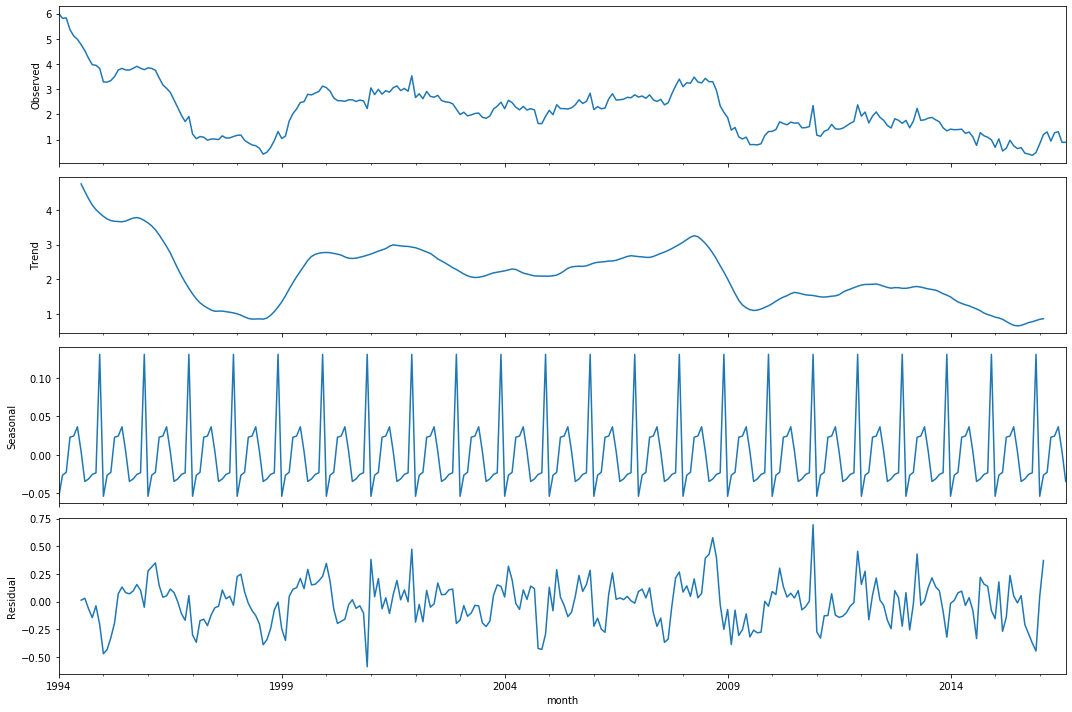

In [11]:
wage['WAG_C_M_box_diff'] = wage['WAG_C_M_box'] - wage['WAG_C_M_box'].shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage['WAG_C_M_box_diff'][12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage['WAG_C_M_box_diff'][12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

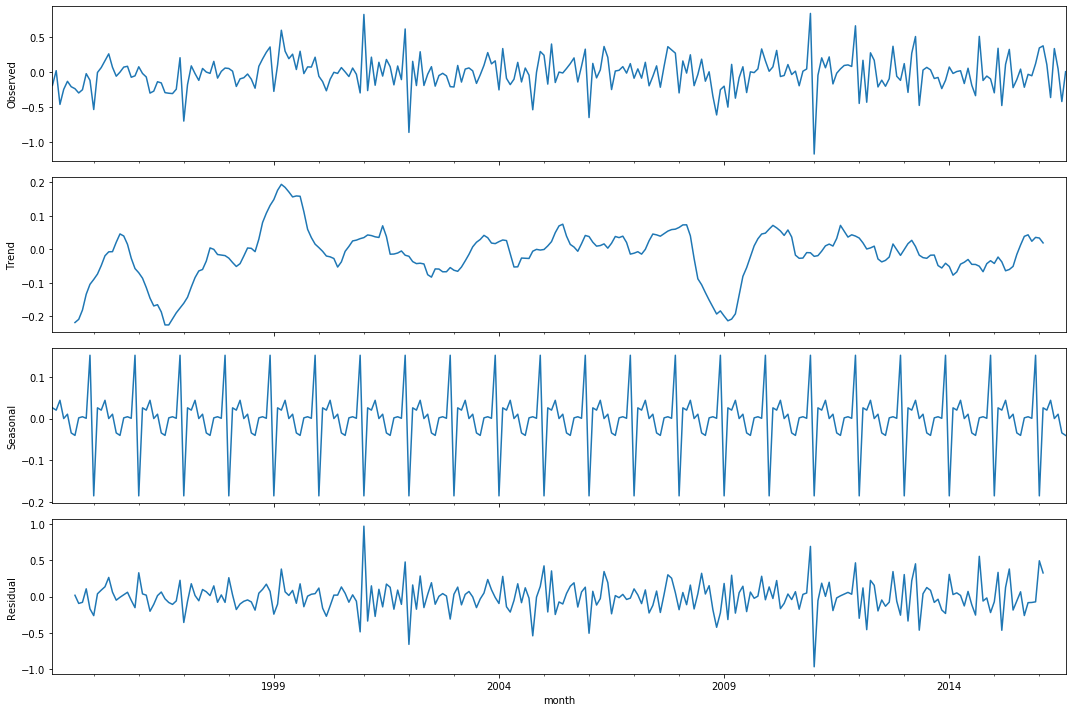

In [12]:
wage['WAG_C_M_box_diff2'] = wage['WAG_C_M_box_diff'] - wage['WAG_C_M_box_diff'].shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage['WAG_C_M_box_diff2'][13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage['WAG_C_M_box_diff2'][13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

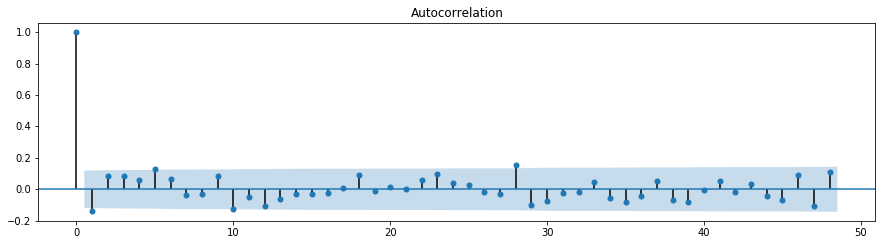

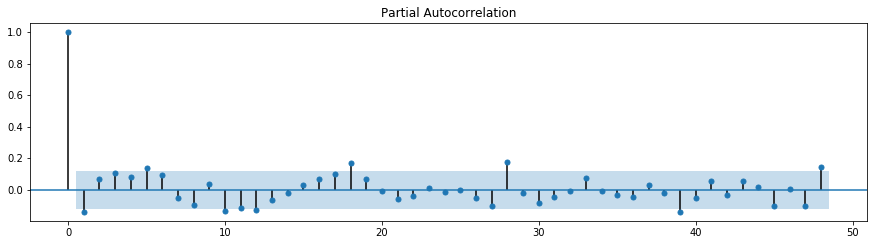

In [32]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wage['WAG_C_M_box_diff2'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wage['WAG_C_M_box_diff2'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=0, q=5, P=4, p=11

In [16]:
ps = range(0, 12)
d=1 # было применено одно не сезонное дифференцирование
qs = range(0, 6)
Ps = range(0, 5)
D=1 # было применено одно сезонное дифференцирование
Qs = range(0, 1)

In [17]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

360

In [18]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wage['WAG_C_M_box'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 1h 1min


In [19]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
176  (5, 5, 1, 0) -24.909425
201  (6, 4, 1, 0) -24.741546
146  (4, 5, 1, 0) -24.190708
177  (5, 5, 2, 0) -23.362354
206  (6, 5, 1, 0) -22.652339


Лучшая модель:

In [20]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.455
Date:                            Sun, 26 Apr 2020   AIC                            -24.909
Time:                                    13:57:58   BIC                             18.316
Sample:                                01-01-1993   HQIC                            -7.554
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2245      0.658     -0.341      0.733      -1.515       1.065
ar.L2          0.2336      0.459   

Её остатки:

Критерий Стьюдента: p=0.159019
Критерий Дики-Фуллера: p=0.000000


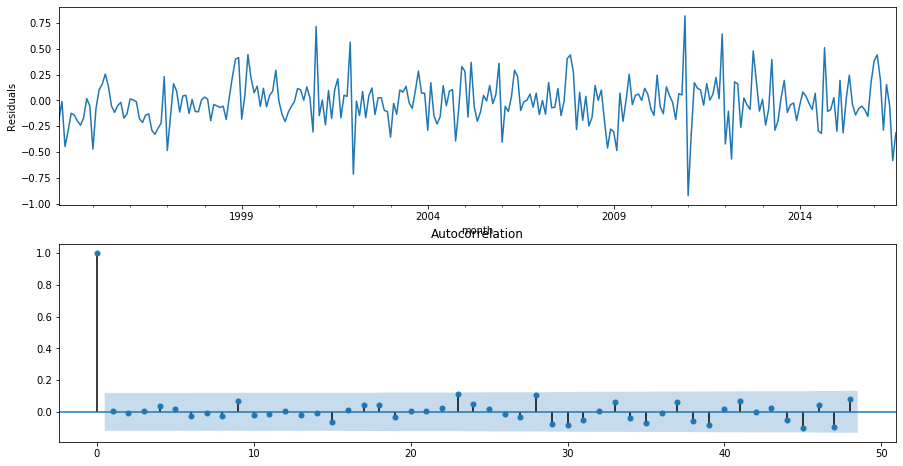

In [21]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

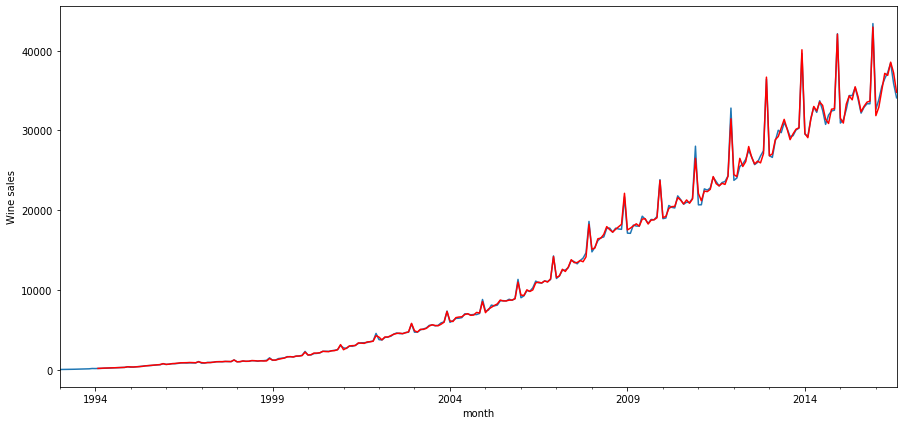

In [25]:
wage['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
wage['WAG_C_M'].plot()
wage['model'][13:].plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

### Прогноз

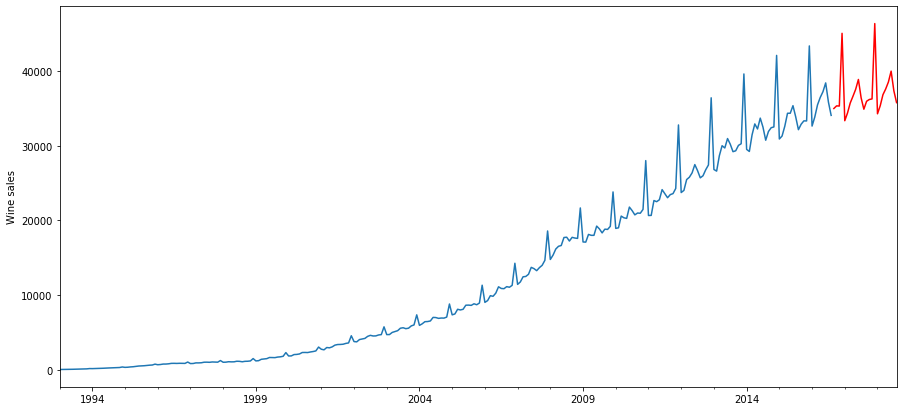

In [35]:
wage2 = wage[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= wage2.columns)
wage2 = pd.concat([wage2, future])
wage2['forecast'] = invboxcox(best_model.predict(start=284, end=307), lmbda)

plt.figure(figsize(15,7))
wage2.WAG_C_M.plot()
wage2.forecast.plot(color='r')
plt.ylabel('Wine sales')
pylab.show()